# Setting up a latent function Gaussian Process

Let us start by importing Turing.jl, the library we will use to write our statistical model and our GaussianProcess.jl package. \
The rest of the imports will only be used to generate the data and plot. 

In [1]:
using Turing
using Distances
using LinearAlgebra
using LimberJack

In [2]:
using Interpolations
using GaussianProcess
using Plots

### 1. Get the Hz data
This time we will apply a non-linear transformation to our data.

In [3]:
function CC()
    z = [
        0.07, 0.09, 0.12, 0.17, 0.179, 0.199, 0.2,
        0.27, 0.28, 0.352, 0.38, 0.3802, 0.4,
        0.4004, 0.4247, 0.44, 0.4497, 0.47, 0.4783,
        0.48, 0.51, 0.593, 0.6, 0.61, 0.68, 0.73,
        0.781, 0.875, 0.88, 0.9, 1.037, 1.3,
        1.363, 1.43, 1.53, 1.75, 1.965
    ]

    data = [
        69.0, 69.0, 68.6, 83.0, 75.0, 75.0, 72.9,
        77.0, 88.8, 83.0, 81.5, 83.0, 95.0, 77.0,
        87.1, 82.6, 92.8, 89.0, 80.9, 97.0, 90.4,
        104.0, 87.9, 97.3, 92.0, 97.3, 105.0,
        125.0, 90.0, 117.0, 154.0, 168.0, 160.0,
        177.0, 140.0, 202.0, 186.5
    ]

    err = [
        19.6, 12.0, 26.2, 8.0, 4.0, 5.0, 29.6,
        14.0, 36.6, 14.0, 1.9, 13.5, 17.0, 10.2,
        11.2, 7.8, 12.9, 23.0, 9.0, 62.0, 1.9,
        13.0, 6.1, 2.1, 8.0, 7.0, 12.0, 17.0,
        40.0, 23.0, 20.0, 17.0, 33.6, 18.0,
        14.0, 40.0, 50.4
    ]

    cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end

    return (
        data_name = "CC",
        z = z,
        data = data,
        cov = cov
    )
end


CC (generic function with 1 method)

In [4]:
function BOSSDR12()
    z = [0.38, 0.51, 0.61]
    data = [81.2087, 90.9029, 98.9647]
    cov = [5.00049e+02 2.94536e+02 1.42011e+02; 2.94536e+02 7.02299e+02 4.32750e+02; 1.42011e+02 4.32750e+02 1.01718e+03]
    return (data_name = "BOSSDR12", z = z, data = data, cov = cov)
end

BOSSDR12 (generic function with 1 method)

In [5]:
cc = CC();
bossdr12 = BOSSDR12();

In [6]:
hubble_data  = [bossdr12.data; cc.data];
zh = [bossdr12.z; cc.z];

In [7]:
covariance = zeros(length(bossdr12.data)+ length(cc.data), length(bossdr12.data)+ length(cc.data));
for i in 1:length(bossdr12.data)
    for j in 1:length(bossdr12.data)
        covariance[i,j] = bossdr12.cov[i,j]
    end
end

for i in 1:length(cc.data)
    for j in 1:length(cc.data)
        covariance[i+length(bossdr12.data), j+length(bossdr12.data)] = cc.cov[i,j]
    end
end


In [8]:
zcont = range(0, 2.5, length=24);
cosmo1 = Cosmology();
H1 = cosmo1.cpar.h*100*Ez(cosmo1, zcont);

In [9]:
omegam = 0.3
omegab = 0.05
hc = 0.67

0.67

### 2. Check what our priors look like

In [10]:
function model_latent_GP(eta, l, v;  
                         X=zcont, data_x=zh, data_cov=covariance)
    # Dimensions of predictors .
    kernel = sqexp_cov_fn(X; eta=eta, l=l)
    cpar = CosmoPar(Ωm=omegam,  Ωb=omegab, h=hc)
    mean_hz = cpar.h*100*Ez(cpar, X)
    gp = latent_GP(mean_hz, v, kernel)
    y =  conditional(X, data_x, gp, sqexp_cov_fn;
                     eta=eta, l=l)
    return gp, y
end

model_latent_GP (generic function with 1 method)

In [18]:
N_samples = 100
gps=zeros(N_samples, 24)
ys=zeros(N_samples, 40)
for i in 1:N_samples
    eta = 200*rand(Uniform(0., 0.1))
    l = 0.02*rand(Uniform(0.1, 3))
    v = rand(MvNormal(zeros(length(zcont)), ones(length(zcont))))
    gps[i, :], ys[i, :] = model_latent_GP(eta, l, v)
end

y_m, y_s = mean(ys, dims=1), std(ys, dims=1);
gp_m, gp_s = mean(gps, dims=1), std(gps, dims=1);

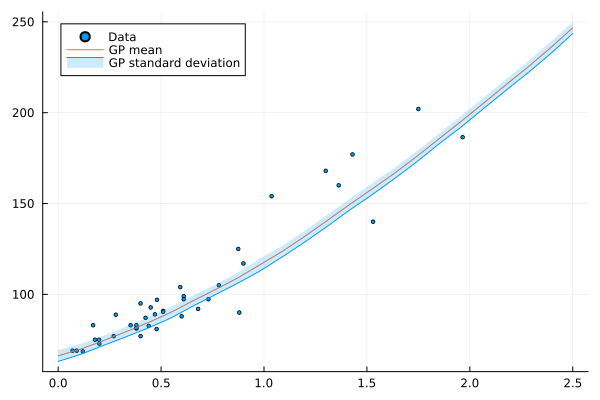

In [19]:
plot(zh, hubble_data, label="Data", ms=2, seriestype=:scatter)
#plot!(zcont, H1)
plot!(zcont, vec(gp_m), label="GP mean")
plot!(zcont, vec(gp_m .- gp_s),  fillrange = vec(gp_m .+ gp_s), fillalpha=0.2, c=1, label="GP standard deviation")

### 3. Define our statistical model

In [21]:
@model function stats_model(y; X=zcont, data_x=zh, data_cov=covariance)
    # Priors.
    eta ~ 200*Uniform(0.0, 0.1)
    l ~ 0.02*Uniform(0.1, 3)
    v ~ MvNormal(zeros(length(X)), ones(length(X)))
    kernel = sqexp_cov_fn(X, eta=eta, l=l)
    cpar = CosmoPar(Ωm=omegam,  Ωb=omegab, h=hc)
    mean_hz = cpar.h*100*Ez(cpar, X)
    gp = latent_GP(mean_hz, v, kernel)
    m = conditional(X, data_x, gp, sqexp_cov_fn; eta=eta, l=l)
    y ~ MvNormal(m, data_cov)
end

stats_model (generic function with 2 methods)

### 4. Sample the model

In [22]:
chain = sample(stats_model(hubble_data), NUTS(100, 0.65), 1000)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/vis09/.julia/packages/Turing/wjl7M/src/inference/hmc.jl:192
Sampling   0%|▎                                         |  ETA: 3:23:52
Sampling   1%|▍                                         |  ETA: 1:42:39
Sampling   1%|▋                                         |  ETA: 1:08:39
Sampling   2%|▊                                         |  ETA: 0:51:34
Sampling   2%|█                                         |  ETA: 0:41:24
Sampling   3%|█▏                                        |  ETA: 0:34:31
Sampling   3%|█▍                                        |  ETA: 0:29:35
Sampling   4%|█▌                                        |  ETA: 0:25:59
Sampling   4%|█▊                                        |  ETA: 0:23:17
Sampling   5%|█▉                                        |  ETA: 0:21:01
Sampling   5%|██▏                                       |  ETA: 0:19:06
Sampling 

Chains MCMC chain (1000×38×1 Array{Float64, 3}):

Iterations        = 101:1:1100
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 109.48 seconds
Compute duration  = 109.48 seconds
parameters        = eta, l, v[1], v[2], v[3], v[4], v[5], v[6], v[7], v[8], v[9], v[10], v[11], v[12], v[13], v[14], v[15], v[16], v[17], v[18], v[19], v[20], v[21], v[22], v[23], v[24]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

         eta    7.5208    5.5323     0.1749    0.2892    270.0308    1.0024    ⋯
           l    0.0335    0.0156     0.0005    0.0009    362.6831    1.0032    ⋯
        v[1]    0.1809    0.9108     0.0288    0.0272   1207.0365  

### 5. Check how our posteriors look like

In [23]:
eta_p = group(chain, :eta).value.data[:, :, 1];
l_p = group(chain, :l).value.data[:, :, 1];
v_p = group(chain, :v).value.data[:, :, 1];

In [ ]:
println(length(eta_p))

In [24]:
N_samples2 = length(eta_p)
gps2=zeros(N_samples2, 24)
ys2=zeros(N_samples2, 100)
for i in 1:N_samples2
    gps2[i, :], ys2[i, :] = model_latent_GP(eta_p[i], l_p[i], v_p[i, :];
                                                data_x=LinRange(0, 7, 100))
end

y_m2, y_s2 = mean(ys2, dims=1), std(ys2, dims=1);
gp_m2, gp_s2 = mean(gps2, dims=1), std(gps2, dims=1);

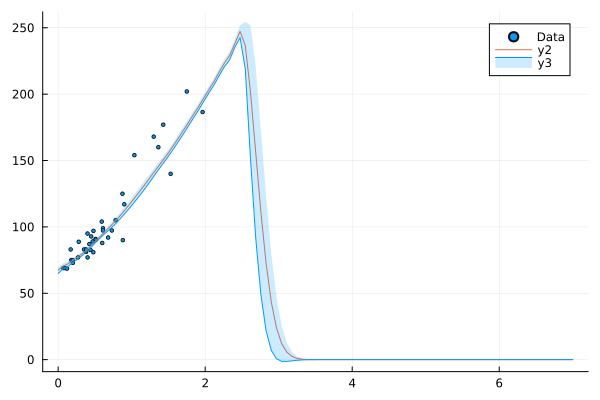

In [ ]:
plot(zh, hubble_data, label="Data", ms=2, seriestype=:scatter)
#plot!(zcont, H1, label="LCDM")
plot!(LinRange(0, 7, 100), vec(y_m2))
plot!(LinRange(0, 7, 100), vec(y_m2 .- y_s2),  fillrange = vec(y_m2 .+ y_s2), fillalpha=0.2, c=1)


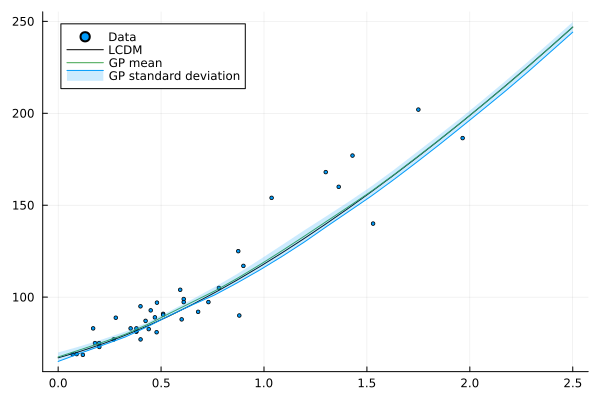

In [30]:
plot(zh, hubble_data, label="Data", ms=2, seriestype=:scatter)
plot!(zcont, H1, label="LCDM", lc=:black)
plot!(zcont, vec(gp_m2), label="GP mean")
plot!(zcont, vec(gp_m2 .- gp_s2),  fillrange = vec(gp_m2 .+ gp_s2), fillalpha=0.2, c=1, label="GP standard deviation")